In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Layer
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Input, Flatten, Dropout
from keras import metrics
from keras.metrics import TopKCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import L2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

In [ ]:
data = tf.keras.datasets.cifar10

In [ ]:
(X_tr, y_tr), (X_t, y_t) = data.load_data()

In [ ]:
print(f"Total samples in dataset = {len(y_tr) + len(y_t)}")
print(f"Total samples in training = {len(y_tr)}")
print(f"Total samples in testing = {len(y_t)}")

Total samples in dataset = 60000
Total samples in training = 50000
Total samples in testing = 10000


[0] 0


Text(0.5, 1.0, 'Image number 21339 -> airplane')

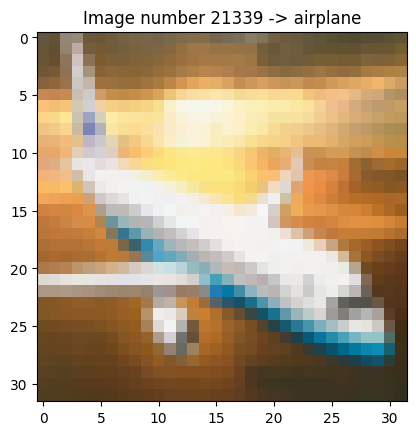

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, len(y_tr))
image, val = X_tr[idx], y_tr[idx]
plt.imshow(image)
print(val, val[0])
s = f"Image number {idx+1} -> " + labels[int(val[0])]
plt.title(s)

In [ ]:
def preprocess_pipeline(X, y):
  print(f"X_train shape = {X.shape} | y_train shape = {y.shape}")
  X_ret = X / 255
  encoder = OneHotEncoder()
  y_ret = encoder.fit_transform(y)
  print("Categories One-Hot Encoder: ", encoder.categories_)
  X_ret, y_ret = shuffle(X_ret, y_ret)
  print(f"After One-Hot Encoding: X_train shape = {X_ret.shape} | y_train shape = {y_ret.shape}")
  return X_ret, y_ret.toarray(), encoder

In [ ]:
enc = None
X_train, y_train, enc = preprocess_pipeline(X_tr, y_tr)

X_train shape = (50000, 32, 32, 3) | y_train shape = (50000, 1)
Categories One-Hot Encoder:  [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]
After One-Hot Encoding: X_train shape = (50000, 32, 32, 3) | y_train shape = (50000, 10)


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_train = X_train.reshape(-1, 3072)

In [ ]:
n_components = 64
pca = PCA(n_components)
X_train_PCA = pca.fit_transform(X_train)

In [ ]:
X_train_PCA.shape

(50000, 64)

In [ ]:
n, m = X_train_PCA.shape
model = Sequential([
    Dense(128, input_shape= (m,), activation= 'relu'),
    Dense(256, activation= 'selu'),
    Dense(256, activation = 'selu'),
    Dense(512, activation = 'selu'),
    Dense(10, activation = 'softmax')
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate= 0.001),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 512)               131584    
                                                                 
 dense_24 (Dense)            (None, 10)                5130      
                                                                 
Total params: 243850 (952.54 KB)
Trainable params: 243850 (952.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_acc', min_delta = 1e-2),
    ModelCheckpoint('best_weights',
                    monitor= 'val_acc',
                    verbose = 0,
                    mode = 'max',
                    # save_format = "tf",
                    save_best_only = True)
]

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(X_train_PCA, y_train, verbose= 1, epochs = 20, batch_size = 256, callbacks = callbacks, validation_split = 0.2)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 1.7771 - accuracy: 0.3714

157/157 [==============================] - 13s 38ms/step - loss: 1.7771 - accuracy: 0.3714 - val_loss: 1.6608 - val_accuracy: 0.4114
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 1.5752 - accuracy: 0.4375

157/157 [==============================] - 6s 35ms/step - loss: 1.5752 - accuracy: 0.4375 - val_loss: 1.5785 - val_accuracy: 0.4306
Epoch 3/20
155/157 [============================>.] - ETA: 0s - loss: 1.4775 - accuracy: 0.4721

157/157 [==============================] - 6s 35ms/step - loss: 1.4771 - accuracy: 0.4724 - val_loss: 1.5200 - val_accuracy: 0.4616
Epoch 4/20
154/157 [============================>.] - ETA: 0s - loss: 1.4114 - accuracy: 0.4940

157/157 [==============================] - 3s 20ms/step - loss: 1.4112 - accuracy: 0.4937 - val_loss: 1.4649 - val_accuracy: 0.4774
Epoch 5/20
156/157 [============================>.] - ETA: 0s - loss: 1.3552 - accuracy: 0.5133

157/157 [==============================] - 2s 15ms/step - loss: 1.3552 - accuracy: 0.5134 - val_loss: 1.4764 - val_accuracy: 0.4847
Epoch 6/20
155/157 [============================>.] - ETA: 0s - loss: 1.3088 - accuracy: 0.5323

157/157 [==============================] - 4s 23ms/step - loss: 1.3090 - accuracy: 0.5324 - val_loss: 1.4548 - val_accuracy: 0.4892
Epoch 7/20
153/157 [============================>.] - ETA: 0s - loss: 1.2698 - accuracy: 0.5464

157/157 [==============================] - 2s 16ms/step - loss: 1.2694 - accuracy: 0.5468 - val_loss: 1.4220 - val_accuracy: 0.4960
Epoch 8/20
153/157 [============================>.] - ETA: 0s - loss: 1.2353 - accuracy: 0.5572

157/157 [==============================] - 2s 16ms/step - loss: 1.2355 - accuracy: 0.5567 - val_loss: 1.4017 - val_accuracy: 0.5065
Epoch 9/20
154/157 [============================>.] - ETA: 0s - loss: 1.1999 - accuracy: 0.5703

157/157 [==============================] - 2s 16ms/step - loss: 1.2006 - accuracy: 0.5700 - val_loss: 1.3936 - val_accuracy: 0.5159
Epoch 10/20
155/157 [============================>.] - ETA: 0s - loss: 1.1711 - accuracy: 0.5812

157/157 [==============================] - 3s 18ms/step - loss: 1.1707 - accuracy: 0.5813 - val_loss: 1.4010 - val_accuracy: 0.5071
Epoch 11/20
155/157 [============================>.] - ETA: 0s - loss: 1.1368 - accuracy: 0.5929

157/157 [==============================] - 3s 21ms/step - loss: 1.1370 - accuracy: 0.5926 - val_loss: 1.4345 - val_accuracy: 0.5045
Epoch 12/20
154/157 [============================>.] - ETA: 0s - loss: 1.1052 - accuracy: 0.6048

157/157 [==============================] - 2s 15ms/step - loss: 1.1056 - accuracy: 0.6046 - val_loss: 1.4236 - val_accuracy: 0.5135
Epoch 13/20
154/157 [============================>.] - ETA: 0s - loss: 1.0746 - accuracy: 0.6147

157/157 [==============================] - 2s 15ms/step - loss: 1.0744 - accuracy: 0.6151 - val_loss: 1.4242 - val_accuracy: 0.5185
Epoch 14/20
155/157 [============================>.] - ETA: 0s - loss: 1.0453 - accuracy: 0.6259

157/157 [==============================] - 3s 21ms/step - loss: 1.0459 - accuracy: 0.6257 - val_loss: 1.4348 - val_accuracy: 0.5127
Epoch 15/20
157/157 [==============================] - ETA: 0s - loss: 1.0183 - accuracy: 0.6360

157/157 [==============================] - 6s 38ms/step - loss: 1.0183 - accuracy: 0.6360 - val_loss: 1.4377 - val_accuracy: 0.5165
Epoch 16/20
153/157 [============================>.] - ETA: 0s - loss: 0.9842 - accuracy: 0.6470

157/157 [==============================] - 2s 16ms/step - loss: 0.9859 - accuracy: 0.6465 - val_loss: 1.4719 - val_accuracy: 0.5151
Epoch 17/20
155/157 [============================>.] - ETA: 0s - loss: 0.9549 - accuracy: 0.6603

157/157 [==============================] - 2s 16ms/step - loss: 0.9550 - accuracy: 0.6599 - val_loss: 1.4844 - val_accuracy: 0.5105
Epoch 18/20
156/157 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.6694

157/157 [==============================] - 2s 16ms/step - loss: 0.9255 - accuracy: 0.6697 - val_loss: 1.5218 - val_accuracy: 0.5091
Epoch 19/20
157/157 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.6779

157/157 [==============================] - 5s 34ms/step - loss: 0.8989 - accuracy: 0.6779 - val_loss: 1.5231 - val_accuracy: 0.5038
Epoch 20/20
153/157 [============================>.] - ETA: 0s - loss: 0.8652 - accuracy: 0.6896

157/157 [==============================] - 2s 16ms/step - loss: 0.8646 - accuracy: 0.6899 - val_loss: 1.5611 - val_accuracy: 0.5146


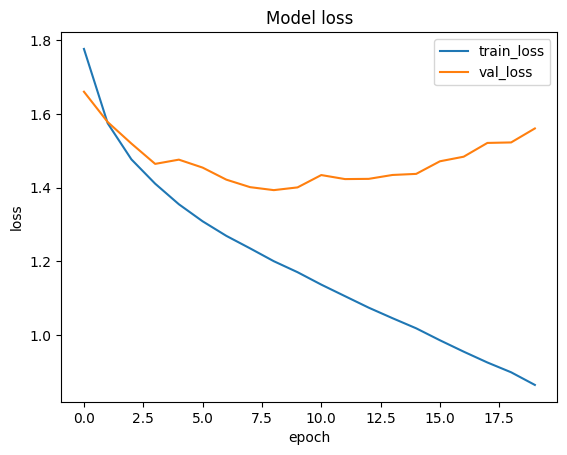

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

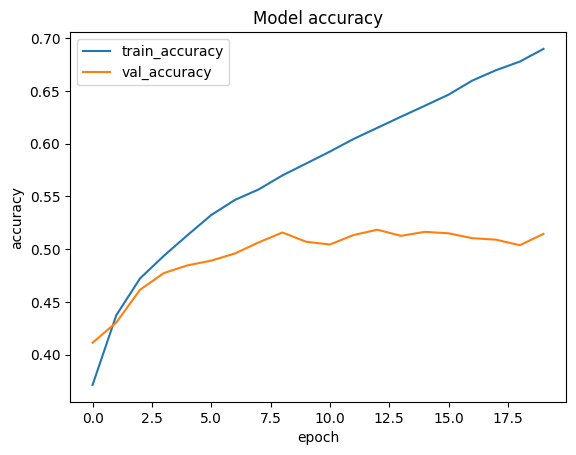

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
model.save_weights("model_weights_ann.h5")

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.777063,0.371400,1.660847,0.4114
1,1.575179,0.437475,1.578519,0.4306
2,1.477086,0.472350,1.520034,0.4616
3,1.411151,0.493700,1.464852,0.4774
4,1.355207,0.513350,1.476370,0.4847


In [ ]:
def plot_training_stats(data):
  n = len(df)
  plt.figure(figsize=(10, 7))
  plt.subplot(121)
  plt.plot([i for i in range(1, n+1)], data['loss'], c='r')
  plt.plot([i for i in range(1, n+1)], data['val_loss'], c='b')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Loss vs Epochs')
  plt.legend(["Loss", "Val_loss"])
  plt.subplot(122)
  plt.plot([i for i in range(1, n+1)], data['accuracy'], c='r')
  plt.plot([i for i in range(1, n+1)], data['val_accuracy'], c='b')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title('Accuracy vs Epochs')
  plt.legend(["Accuracy", "Val_Accuracy"])

  plt.show()

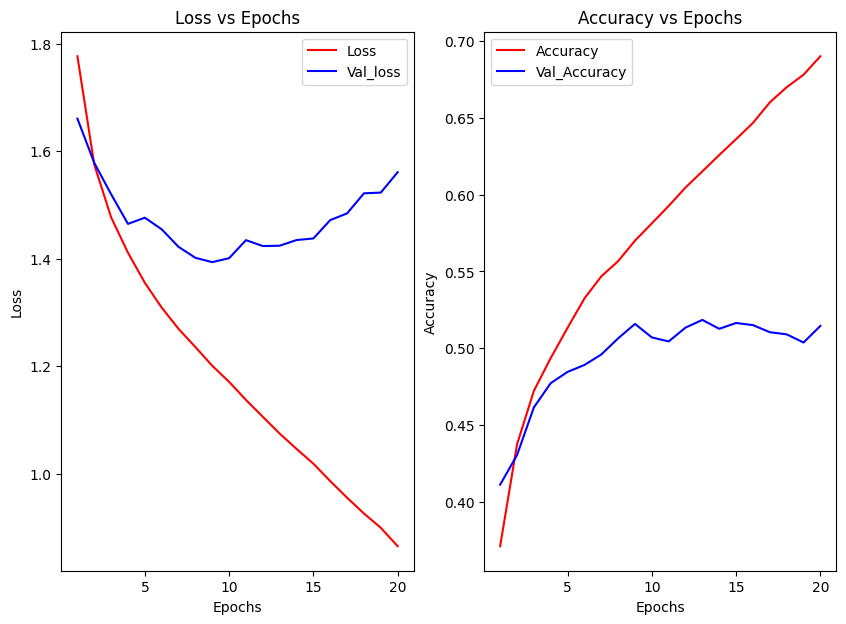

In [ ]:
plot_training_stats(df)

In [ ]:
# model = get_model(tf.zeros((256, 32, 32, 3), dtype= float))
model.load_weights("model_weights_ann.h5")

In [ ]:
def evaluate(y_pred, y_true, encoder):
  corr = 0
  print(y_pred.shape, y_true.shape)
  for i in range(len(y_true)):
    if np.argmax(y_pred[i]) == y_true[i]:
      corr+=1
  return corr, corr / len(y_true)

In [ ]:
def eval_pipeline(X, y, enc, mdl, pca):
  X_t = X / 255
  X_t = X_t.reshape(-1, 3072)
  X_t_PCA = pca.fit_transform(X_t)
  print(X_t_PCA.shape)
  y_t = enc.transform(y)
  y_preds = mdl.predict(X_t_PCA)
  c, a = evaluate(y_preds, y, enc)
  print(f"Correct = {c} | Accuracy = {a}")
  return y_preds

In [ ]:
preds = eval_pipeline(X_t, y_t, enc, model, pca)

(10000, 64)
313/313 [==============================] - 2s 7ms/step
(10000, 10) (10000, 1)
Correct = 1924 | Accuracy = 0.1924


In [ ]:
pred_lbls = np.argmax(preds, axis = 1)
n, m = len(labels), len(pred_lbls)
matrix = np.zeros((n, n))
for _ in range(m):
  matrix[pred_lbls[_]][y_t[_]] += 1

In [ ]:
pred_lbls

array([1, 9, 8, ..., 3, 4, 4])

Text(0.5, 1.0, 'Confusion Matrix')

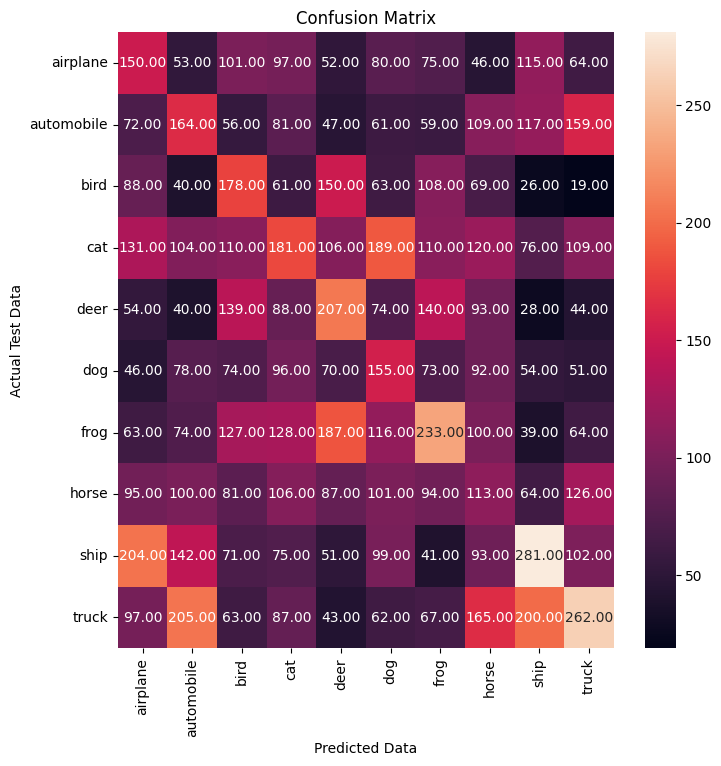

In [ ]:
import seaborn as sns
plt.figure(figsize= (8, 8))
sns.heatmap(matrix, annot=True, fmt= '.2f', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Data")
plt.ylabel("Actual Test Data")
plt.title("Confusion Matrix")

In [ ]:
def random_testing(X, y, lbl, y_preds= None):
  n = len(y)
  idx = np.random.randint(0, n)
  image, val = X[idx], int(y[idx][0])
  plt.imshow(image)
  s = f"Image number {idx+1} -> " + lbl[val]
  plt.title(s)

  if len(y_preds) != 0:
    pred_val = int(np.argmax(y_preds[idx]))
    print(f"Predicted Value = {lbl[pred_val]} | True Value = {lbl[val]} | Verdict = {True if pred_val == val else False}")

Predicted Value = dog | True Value = horse | Verdict = False


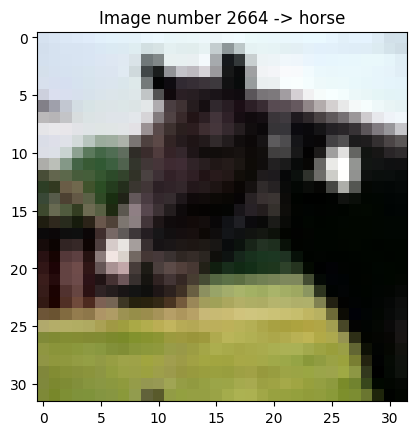

In [ ]:
random_testing(X_t, y_t, labels, preds)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, top_k_accuracy_score, precision_score, recall_score, precision_recall_curve

In [ ]:
true_lbls = y_t.reshape(-1, )
print("F1 Score: ", f1_score(true_lbls, pred_lbls, average= "weighted"))
print("Accuracy Score: ", accuracy_score(true_lbls, pred_lbls))
print("Precision Score: ", precision_score(true_lbls, pred_lbls, average= "weighted"))
print("Recall Score: ", recall_score(true_lbls, pred_lbls, average= "weighted"))

F1 Score:  0.1910549903294645
Accuracy Score:  0.1924
Precision Score:  0.19251821912733239
Recall Score:  0.1924
